In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 666)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 888)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [6]:
# 人工评估模型优劣的方法太蠢了，因此使用sklearn中的网格搜索或随机搜索来完成过程
# 使用随机搜索

# 由于需要使用sklearn中的模型，因此自定义模型创建的函数，
# 使用keras的接口tensorflow.keras.wrappers.scikit_learn.KerasRegressor()
# 转换为sklearn的模型

# 定义关键字参数，指定隐藏层层数，每层神经元数，学习率
def build_model(hidden_layers=1, 
                layer_size=30,
                learning_rate=3e-3):
    
    # 初始化模型
    model = keras.models.Sequential()
    
    # 设置输入层，数据形状需要从训练集数据的shape属性中获得，而且传入的是一个元组
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    
    # 设置隐藏层
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation='relu'))
        
    # 设置输出层
    model.add(keras.layers.Dense(1))
    
    # 指定优化器
    optimizer = keras.optimizers.SGD(learning_rate)
    
    # 编译模型，指定损失函数
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

# 使用转换接口将keras模型转换为sklearn模型，build_fn指定模型创建使用的函数
sk_model = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)

# 指定回调函数
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

# 进行模型训练
history = sk_model.fit(x_train_scaled, y_train,
                            epochs=10,
                            validation_data=(x_valid_scaled, y_valid),
                            callbacks=callbacks)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.0957 - val_loss: 0.6424
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6311 - val_loss: 0.5643
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5686 - val_loss: 0.5215
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5295 - val_loss: 0.4928
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5062 - val_loss: 0.4736
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4881 - val_loss: 0.4661
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4743 - val_loss: 0.4542
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4645 - val_loss: 0.4432
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4583 - val_loss: 0.4441
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4554 - val_loss: 0.4334

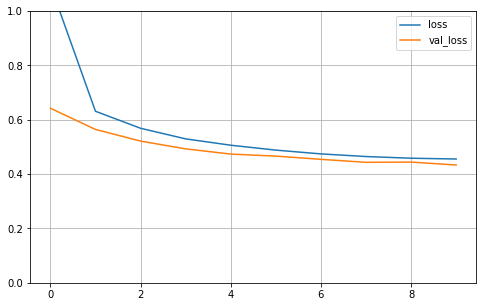

In [9]:
# 查看训练结果，得到大致的训练时默认参数情况
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [10]:
# 开始进行随机搜索

# 指定超参数，使用字典保存
param_distribution = {
    'hidden_layers': [1, 2, 3, 4],
    'layer_size': [5, 10, 20, 30],
    'learning_rate': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
}

from sklearn.model_selection import RandomizedSearchCV

# 初始化随机搜索器，设置搜索模型，超参数，形成参数集合数，任务并行数
random_search_cv = RandomizedSearchCV(sk_model,
                                      param_distribution,
                                      n_iter = 10,
                                      n_jobs = 1)

# 进行模型训练
random_search_cv.fit(x_train_scaled, y_train, epochs=100, 
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks)

Epoch 1/100
291/291 [==============================] - 1s 2ms/step - loss: 0.8888 - val_loss: 0.5584
Epoch 2/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5790 - val_loss: 0.7345
Epoch 3/100
291/291 [==============================] - 0s 2ms/step - loss: 4.4445 - val_loss: 0.5342
Epoch 4/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4827 - val_loss: 0.4699
Epoch 5/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4441 - val_loss: 0.4316
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4258 - val_loss: 0.4175
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4085 - val_loss: 0.3960
Epoch 8/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3900 - val_loss: 0.5403
Epoch 9/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3980 - val_loss: 0.4414
Epoch 10/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3936 - val_lo

291/291 [==============================] - 0s 1ms/step - loss: 0.3718 - val_loss: 0.3604
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3682 - val_loss: 0.3596
Epoch 22/100
73/73 [==============================] - 0s 949us/step - loss: 0.3393
Epoch 1/100
291/291 [==============================] - 0s 2ms/step - loss: 0.9480 - val_loss: 0.5717
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5477 - val_loss: 0.5047
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5008 - val_loss: 0.4905
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4841 - val_loss: 0.4614
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4860 - val_loss: 0.4572
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4625 - val_loss: 0.4584
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4464 - val_loss: 0.4406
Epoch 8/100
291/291

291/291 [==============================] - 0s 2ms/step - loss: 0.3338 - val_loss: 0.3172
Epoch 28/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3245 - val_loss: 0.3191
Epoch 29/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3231 - val_loss: 0.3084
Epoch 30/100
73/73 [==============================] - 0s 932us/step - loss: 0.3355
Epoch 1/100
291/291 [==============================] - 0s 2ms/step - loss: 1.1294 - val_loss: 0.6388
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6184 - val_loss: 0.5583
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5387 - val_loss: 0.4854
Epoch 4/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4874 - val_loss: 0.4465
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4589 - val_loss: 0.4401
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4439 - val_loss: 0.4416
Epoch 7/100
291/29

291/291 [==============================] - 0s 2ms/step - loss: 0.8639 - val_loss: 0.7752
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8028 - val_loss: 0.7262
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7577 - val_loss: 0.6922
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7250 - val_loss: 0.6673
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7011 - val_loss: 0.6503
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6835 - val_loss: 0.6381
Epoch 12/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6704 - val_loss: 0.6288
Epoch 13/100
291/291 [==============================] - 1s 2ms/step - loss: 0.6599 - val_loss: 0.6216
Epoch 14/100
291/291 [==============================] - 1s 2ms/step - loss: 0.6512 - val_loss: 0.6154
Epoch 15/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6435 - val_loss: 0.6

Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5526 - val_loss: 0.5316
Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5500 - val_loss: 0.5289
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5473 - val_loss: 0.5263
Epoch 34/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5448 - val_loss: 0.5237
Epoch 35/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5423 - val_loss: 0.5212
Epoch 36/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5396 - val_loss: 0.5189
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5372 - val_loss: 0.5166
Epoch 38/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5347 - val_loss: 0.5144
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5325 - val_loss: 0.5121
Epoch 40/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5302

291/291 [==============================] - 0s 2ms/step - loss: 0.6724 - val_loss: 0.6573
Epoch 61/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6646 - val_loss: 0.6488
Epoch 62/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6569 - val_loss: 0.6406
Epoch 63/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6494 - val_loss: 0.6325
Epoch 64/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6423 - val_loss: 0.6250
Epoch 65/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6351 - val_loss: 0.6182
Epoch 66/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6285 - val_loss: 0.6105
Epoch 67/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6220 - val_loss: 0.6039
Epoch 68/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6158 - val_loss: 0.5972
Epoch 69/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6099 - val_loss: 

Epoch 46/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5895 - val_loss: 0.5665
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5865 - val_loss: 0.5635
Epoch 48/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5837 - val_loss: 0.5602
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5807 - val_loss: 0.5573
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5781 - val_loss: 0.5541
Epoch 51/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5751 - val_loss: 0.5516
Epoch 52/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5727 - val_loss: 0.5485
Epoch 53/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5699 - val_loss: 0.5458
Epoch 54/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5673 - val_loss: 0.5430
Epoch 55/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5648

73/73 [==============================] - 0s 1ms/step - loss: 0.5638
Epoch 1/100
291/291 [==============================] - 0s 2ms/step - loss: 5.7132 - val_loss: 5.2689
Epoch 2/100
291/291 [==============================] - 0s 2ms/step - loss: 5.1274 - val_loss: 4.7377
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 4.6306 - val_loss: 4.2845
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 4.2034 - val_loss: 3.8930
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 3.8321 - val_loss: 3.5513
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 3.5068 - val_loss: 3.2517
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 3.2206 - val_loss: 2.9878
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 2.9678 - val_loss: 2.7555
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 2.7448 - val_loss: 2.5502
Epoch 10/100
291/291 [=

291/291 [==============================] - 0s 2ms/step - loss: 1.0851 - val_loss: 1.0622
Epoch 81/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0748 - val_loss: 1.0523
Epoch 82/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0643 - val_loss: 1.0421
Epoch 83/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0536 - val_loss: 1.0317
Epoch 84/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0426 - val_loss: 1.0212
Epoch 85/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0315 - val_loss: 1.0105
Epoch 86/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0201 - val_loss: 0.9996
Epoch 87/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0087 - val_loss: 0.9886
Epoch 88/100
291/291 [==============================] - 0s 1ms/step - loss: 0.9972 - val_loss: 0.9775
Epoch 89/100
291/291 [==============================] - 0s 1ms/step - loss: 0.9856 - val_loss: 

291/291 [==============================] - 1s 3ms/step - loss: 3.6229 - val_loss: 3.3852
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 3.2508 - val_loss: 3.0365
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 2.9137 - val_loss: 2.7213
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 2.6103 - val_loss: 2.4404
Epoch 8/100
291/291 [==============================] - 1s 3ms/step - loss: 2.3407 - val_loss: 2.1901
Epoch 9/100
291/291 [==============================] - 1s 2ms/step - loss: 2.1029 - val_loss: 1.9723
Epoch 10/100
291/291 [==============================] - 1s 2ms/step - loss: 1.8981 - val_loss: 1.7862
Epoch 11/100
291/291 [==============================] - 1s 2ms/step - loss: 1.7258 - val_loss: 1.6296
Epoch 12/100
291/291 [==============================] - 0s 2ms/step - loss: 1.5815 - val_loss: 1.5015
Epoch 13/100
291/291 [==============================] - 0s 2ms/step - loss: 1.4645 - val_loss: 1.397

Epoch 17/100
291/291 [==============================] - 0s 2ms/step - loss: 1.3403 - val_loss: 1.2067
Epoch 18/100
291/291 [==============================] - 1s 2ms/step - loss: 1.2948 - val_loss: 1.1671
Epoch 19/100
291/291 [==============================] - 1s 2ms/step - loss: 1.2578 - val_loss: 1.1365
Epoch 20/100
291/291 [==============================] - 1s 2ms/step - loss: 1.2276 - val_loss: 1.1123
Epoch 21/100
291/291 [==============================] - 1s 2ms/step - loss: 1.2020 - val_loss: 1.0918
Epoch 22/100
291/291 [==============================] - 1s 2ms/step - loss: 1.1798 - val_loss: 1.0746
Epoch 23/100
291/291 [==============================] - 1s 2ms/step - loss: 1.1607 - val_loss: 1.0596
Epoch 24/100
291/291 [==============================] - 1s 2ms/step - loss: 1.1436 - val_loss: 1.0463
Epoch 25/100
291/291 [==============================] - 1s 2ms/step - loss: 1.1282 - val_loss: 1.0349
Epoch 26/100
291/291 [==============================] - 1s 2ms/step - loss: 1.1144

291/291 [==============================] - 0s 2ms/step - loss: 5.6146 - val_loss: 5.1144
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 4.6917 - val_loss: 4.3201
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 3.9860 - val_loss: 3.6874
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 3.4121 - val_loss: 3.1628
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 2.9374 - val_loss: 2.7354
Epoch 6/100
291/291 [==============================] - 0s 2ms/step - loss: 2.5670 - val_loss: 2.4152
Epoch 7/100
291/291 [==============================] - 0s 2ms/step - loss: 2.2982 - val_loss: 2.1832
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 2.1040 - val_loss: 2.0173
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 1.9648 - val_loss: 1.8969
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 1.8628 - val_loss: 1.8070
E

291/291 [==============================] - 0s 2ms/step - loss: 0.8751 - val_loss: 0.8264
Epoch 82/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8701 - val_loss: 0.8212
Epoch 83/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8651 - val_loss: 0.8163
Epoch 84/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8603 - val_loss: 0.8116
Epoch 85/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8556 - val_loss: 0.8069
Epoch 86/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8511 - val_loss: 0.8025
Epoch 87/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8468 - val_loss: 0.7984
Epoch 88/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8425 - val_loss: 0.7944
Epoch 89/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8385 - val_loss: 0.7905
Epoch 90/100
291/291 [==============================] - 0s 2ms/step - loss: 0.8345 - val_loss: 

291/291 [==============================] - 0s 2ms/step - loss: 0.5089 - val_loss: 0.4839
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4936 - val_loss: 0.4704
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4801 - val_loss: 0.4622
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4702 - val_loss: 0.4491
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4604 - val_loss: 0.4459
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4508 - val_loss: 0.4376
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4437 - val_loss: 0.4342
Epoch 14/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4438 - val_loss: 0.4283
Epoch 15/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4330 - val_loss: 0.4179
Epoch 16/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4274 - val_loss: 0.

291/291 [==============================] - 0s 2ms/step - loss: 0.3645 - val_loss: 0.3743
Epoch 26/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3632 - val_loss: 0.3785
Epoch 27/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3608 - val_loss: 0.3638
Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3573 - val_loss: 0.3594
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3553 - val_loss: 0.3672
Epoch 30/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3542 - val_loss: 0.3516
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3528 - val_loss: 0.3538
Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3495 - val_loss: 0.3583
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3483 - val_loss: 0.3655
Epoch 34/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3454 - val_loss: 

Epoch 70/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6093 - val_loss: 0.6019
Epoch 71/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6073 - val_loss: 0.5998
Epoch 72/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6049 - val_loss: 0.5974
Epoch 73/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6027 - val_loss: 0.5951
Epoch 74/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6003 - val_loss: 0.5934
Epoch 75/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5983 - val_loss: 0.5906
Epoch 76/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5960 - val_loss: 0.5884
Epoch 77/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5865
Epoch 78/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5914 - val_loss: 0.5841
Epoch 79/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5892

291/291 [==============================] - 0s 2ms/step - loss: 0.4987 - val_loss: 0.4763
Epoch 50/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4960 - val_loss: 0.4742
Epoch 51/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4935 - val_loss: 0.4726
Epoch 52/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4911 - val_loss: 0.4698
Epoch 53/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4892 - val_loss: 0.4678
Epoch 54/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4870 - val_loss: 0.4669
Epoch 55/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4850 - val_loss: 0.4646
Epoch 56/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4832 - val_loss: 0.4628
Epoch 57/100
73/73 [==============================] - 0s 984us/step - loss: 0.4633
Epoch 1/100
291/291 [==============================] - 0s 2ms/step - loss: 4.6317 - val_loss: 3.5057
Epoch 2/100
2

291/291 [==============================] - 0s 2ms/step - loss: 0.7029 - val_loss: 0.6828
Epoch 8/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6857 - val_loss: 0.6654
Epoch 9/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6722 - val_loss: 0.6517
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6614 - val_loss: 0.6415
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6529 - val_loss: 0.6320
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6453 - val_loss: 0.6245
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6386 - val_loss: 0.6184
Epoch 14/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6326 - val_loss: 0.6126
Epoch 15/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6277 - val_loss: 0.6069
Epoch 16/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6229 - val_loss: 0.

Epoch 38/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5940 - val_loss: 0.5891
Epoch 39/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5900 - val_loss: 0.5854
Epoch 40/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5864 - val_loss: 0.5819
Epoch 41/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5826 - val_loss: 0.5787
Epoch 42/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5792 - val_loss: 0.5749
Epoch 43/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5756 - val_loss: 0.5719
Epoch 44/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5722 - val_loss: 0.5688
Epoch 45/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5688 - val_loss: 0.5655
Epoch 46/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5654 - val_loss: 0.5615
Epoch 47/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5622

291/291 [==============================] - 0s 2ms/step - loss: 0.5716 - val_loss: 0.5453
Epoch 53/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5693 - val_loss: 0.5433
Epoch 54/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5671 - val_loss: 0.5414
Epoch 55/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5650 - val_loss: 0.5395
Epoch 56/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5629 - val_loss: 0.5376
Epoch 57/100
73/73 [==============================] - 0s 1ms/step - loss: 0.5641
Epoch 1/100
291/291 [==============================] - 1s 2ms/step - loss: 3.5821 - val_loss: 2.7360
Epoch 2/100
291/291 [==============================] - 0s 2ms/step - loss: 2.3288 - val_loss: 1.7710
Epoch 3/100
291/291 [==============================] - 0s 2ms/step - loss: 1.6688 - val_loss: 1.3445
Epoch 4/100
291/291 [==============================] - 0s 2ms/step - loss: 1.3979 - val_loss: 1.1829
Epoch 5/100
291/29

291/291 [==============================] - 1s 2ms/step - loss: 1.0221 - val_loss: 0.9630
Epoch 17/100
291/291 [==============================] - 0s 2ms/step - loss: 0.9823 - val_loss: 0.9263
Epoch 18/100
291/291 [==============================] - 1s 2ms/step - loss: 0.9462 - val_loss: 0.8930
Epoch 19/100
291/291 [==============================] - 1s 2ms/step - loss: 0.9138 - val_loss: 0.8630
Epoch 20/100
291/291 [==============================] - 0s 2ms/step - loss: 0.8847 - val_loss: 0.8359
Epoch 21/100
291/291 [==============================] - 0s 2ms/step - loss: 0.8588 - val_loss: 0.8120
Epoch 22/100
291/291 [==============================] - 1s 2ms/step - loss: 0.8359 - val_loss: 0.7908
Epoch 23/100
291/291 [==============================] - 0s 2ms/step - loss: 0.8159 - val_loss: 0.7724
Epoch 24/100
291/291 [==============================] - 0s 2ms/step - loss: 0.7985 - val_loss: 0.7564
Epoch 25/100
291/291 [==============================] - 1s 2ms/step - loss: 0.7836 - val_loss: 

Epoch 40/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5858 - val_loss: 0.5577
Epoch 41/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5832 - val_loss: 0.5552
Epoch 42/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5807 - val_loss: 0.5527
Epoch 43/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5782 - val_loss: 0.5504
Epoch 44/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5758 - val_loss: 0.5481
Epoch 45/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5735 - val_loss: 0.5458
Epoch 46/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5712 - val_loss: 0.5436
Epoch 47/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5690 - val_loss: 0.5414
Epoch 48/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5668 - val_loss: 0.5393
Epoch 49/100
291/291 [==============================] - 1s 3ms/step - loss: 0.5647

291/291 [==============================] - 0s 2ms/step - loss: 0.9479 - val_loss: 0.8290
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8379 - val_loss: 0.7792
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7954 - val_loss: 0.7548
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7718 - val_loss: 0.7366
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7541 - val_loss: 0.7210
Epoch 8/100
291/291 [==============================] - 0s 2ms/step - loss: 0.7389 - val_loss: 0.7067
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7248 - val_loss: 0.6932
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7118 - val_loss: 0.6809
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6993 - val_loss: 0.6688
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6877 - val_loss: 0.6577

Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5041 - val_loss: 0.4829
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5019 - val_loss: 0.4810
Epoch 34/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4997 - val_loss: 0.4791
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4977 - val_loss: 0.4774
Epoch 36/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4957 - val_loss: 0.4754
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4939 - val_loss: 0.4738
Epoch 38/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4922 - val_loss: 0.4725
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4906 - val_loss: 0.4711
Epoch 40/100
73/73 [==============================] - 0s 926us/step - loss: 0.4862
Epoch 1/100
291/291 [==============================] - 0s 2ms/step - loss: 3.6468 - val_loss: 1.8617


291/291 [==============================] - 0s 1ms/step - loss: 0.5229 - val_loss: 0.5049
Epoch 29/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5202 - val_loss: 0.5012
Epoch 30/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5175 - val_loss: 0.4988
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5146 - val_loss: 0.4948
Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5123 - val_loss: 0.4939
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5101 - val_loss: 0.4900
Epoch 34/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5080 - val_loss: 0.4881
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5059 - val_loss: 0.4856
Epoch 36/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5040 - val_loss: 0.4847
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5020 - val_loss: 

291/291 [==============================] - 1s 2ms/step - loss: 0.5670 - val_loss: 0.5484
Epoch 33/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5639 - val_loss: 0.5458
Epoch 34/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5608 - val_loss: 0.5424
Epoch 35/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5579 - val_loss: 0.5394
Epoch 36/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5551 - val_loss: 0.5365
Epoch 37/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5524 - val_loss: 0.5339
Epoch 38/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5498 - val_loss: 0.5314
Epoch 39/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5473 - val_loss: 0.5288
Epoch 40/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5449 - val_loss: 0.5264
Epoch 41/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5425 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.6242 - val_loss: 0.5916
Epoch 23/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6194 - val_loss: 0.5872
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6142 - val_loss: 0.5837
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6086 - val_loss: 0.5788
Epoch 26/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6047 - val_loss: 0.5751
Epoch 27/100
291/291 [==============================] - 0s 2ms/step - loss: 0.6001 - val_loss: 0.5734
Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5968 - val_loss: 0.5696
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5929 - val_loss: 0.5677
Epoch 30/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5897 - val_loss: 0.5623
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5866 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 1.9543 - val_loss: 1.4336
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 1.1615 - val_loss: 1.0032
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8968 - val_loss: 0.8448
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7913 - val_loss: 0.7782
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7443 - val_loss: 0.7456
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7194 - val_loss: 0.7258
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7031 - val_loss: 0.7108
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6901 - val_loss: 0.6982
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6791 - val_loss: 0.6868
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6688 - val_loss: 0.6763


Epoch 28/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3732 - val_loss: 0.3650
Epoch 29/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3724 - val_loss: 0.3663
Epoch 30/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3715 - val_loss: 0.3731
Epoch 31/100
291/291 [==============================] - 0s 2ms/step - loss: 0.3692 - val_loss: 0.3610
Epoch 32/100
73/73 [==============================] - 0s 1ms/step - loss: 0.3775
Epoch 1/100
291/291 [==============================] - 1s 2ms/step - loss: 1.3287 - val_loss: 0.6589
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.6437 - val_loss: 0.5763
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5714 - val_loss: 0.5328
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5314 - val_loss: 0.5004
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.5030 - val_loss: 0.4761
Epoch 

291/291 [==============================] - 1s 3ms/step - loss: 0.3973 - val_loss: 0.3857
Epoch 21/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3940 - val_loss: 0.3842
Epoch 22/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3919 - val_loss: 0.3793
Epoch 23/100
73/73 [==============================] - 0s 2ms/step - loss: 0.3658
Epoch 1/100
291/291 [==============================] - 1s 2ms/step - loss: 1.0301 - val_loss: 0.7136
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.6384 - val_loss: 0.6085
Epoch 3/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5679 - val_loss: 0.5695
Epoch 4/100
291/291 [==============================] - 0s 2ms/step - loss: 0.5181 - val_loss: 0.5052
Epoch 5/100
291/291 [==============================] - 0s 2ms/step - loss: 0.4780 - val_loss: 0.4707
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4630 - val_loss: 0.4560
Epoch 7/100
291/291 

RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd572218d30>,
                   n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': [5, 10, 20, 30],
                                        'learning_rate': [0.0001, 0.0005, 0.001,
                                                          0.005, 0.01]})

In [11]:
print(random_search_cv.best_params_)  # 最佳参数配置
print(random_search_cv.best_score_)  # 最佳得分
# print(random_search_cv.best_estimator_)  

{'learning_rate': 0.005, 'layer_size': 20, 'hidden_layers': 4}
-0.36923536062240603


In [12]:
# 使用随机搜索得到的最佳模型，并对其进行评估
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3421


0.34213945269584656